In [4]:

import numpy as np
import pandas as pd
import torch
import gymnasium as gym  # use Gym for compatibility with SKRL's wrappers


In [5]:
from gym.vector import SyncVectorEnv
from gym.spaces import Box
from sklearn.preprocessing import StandardScaler

# SKRL imports
from skrl.envs.torch import wrap_env
from skrl.agents.torch.ppo import PPO_DEFAULT_CONFIG, PPO
from skrl.memories.torch import RandomMemory
from skrl.trainers.torch import SequentialTrainer
from skrl.models.torch import Model, GaussianMixin, DeterministicMixin
from skrl.resources.preprocessors.torch import RunningStandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

[skrl:WARNING] Using `from skrl.envs.torch import ...` is deprecated and will be removed in future versions.
[skrl:WARNING]  - Import loaders using `from skrl.envs.loaders.torch import ...`
[skrl:WARNING]  - Import wrappers using `from skrl.envs.wrappers.torch import ...`


In [6]:
import torch.nn as nn

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class TimeSeriesPredictionEnv(gym.Env):
    """Last 6 columns are targets, rest are features."""
    def __init__(self, data: pd.DataFrame, train_ratio: float = 0.8):
        super().__init__()
        self.data = data.reset_index(drop=True)
        self.scaler = StandardScaler()
        
        # Feature/target split  
        self.n_targets = 6
        self.feature_cols = data.columns[:-self.n_targets].tolist()
        self.target_cols = data.columns[-self.n_targets:].tolist()
        
        # Train/test split
        train_size = int(len(data) * train_ratio)
        train_df = data.iloc[:train_size]
        test_df = data.iloc[train_size:]
        
        # Fit & transform
        X_train, X_test = train_df[self.feature_cols], test_df[self.feature_cols]
        self.scaler.fit(X_train)
        self.scaled_train_X = self.scaler.transform(X_train)
        self.scaled_test_X = self.scaler.transform(X_test)
        self.train_y, self.test_y = train_df[self.target_cols].values, test_df[self.target_cols].values
        
        # Spaces
        obs_dim = len(self.feature_cols)
        self.observation_space = Box(low=-20.0, high=20.0, shape=(obs_dim,), dtype=np.float32)
        self.action_space = Box(low=-20.0, high=20.0, shape=(self.n_targets,), dtype=np.float32)
        
        # RNG and initial mode
        self._np_random = None
        self.set_mode(is_training=True)
    
    @property
    def np_random(self):
        if self._np_random is None:
            self._np_random = np.random.RandomState()
        return self._np_random
    
    def seed(self, seed=None):
        self._np_random = np.random.RandomState(seed)
        return [seed]
    
    def set_mode(self, is_training=True):
        self.is_training = is_training
        self.current_x = self.scaled_train_X if is_training else self.scaled_test_X
        self.current_y = self.train_y if is_training else self.test_y
        self.max_steps = len(self.current_x) - 1
        self.current_step = (self.np_random.randint(0, self.max_steps) 
                            if is_training else 0)
        return self.current_x[self.current_step]
    
    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)
        
        self.current_step = (self.np_random.randint(0, self.max_steps) 
                            if self.is_training else 0)
        obs = self.current_x[self.current_step]
        return obs, {"target": self.current_y[self.current_step].copy()}
    
    def step(self, action):
        pred, actual = action, self.current_y[self.current_step]
        #print(f"Pred: {pred}, Actual: {actual}")
        reward = -np.mean((pred - actual)**2)
        
        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        if done:
            self.current_step = (self.np_random.randint(0, self.max_steps) 
                                if self.is_training else 0)
            
        obs = self.current_x[self.current_step]
        return obs, reward, done, False, {"target": actual.copy()}


# Define the value network (V-function) for PPO
class Value(DeterministicMixin, Model):
    def __init__(self, observation_space, action_space, device, clip_actions=False):
        Model.__init__(self, observation_space, action_space, device)
        DeterministicMixin.__init__(self, clip_actions)
        
        self.net = nn.Sequential(
            nn.Linear(self.num_observations, 256),
            nn.LayerNorm(256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
    
    def compute(self, inputs, role):
        return self.net(inputs["states"]), {}


# Define the policy network for PPO
class Policy(GaussianMixin, Model):
    def __init__(self, observation_space, action_space, device, clip_actions=False,
                 clip_log_std=True, min_log_std=-20, max_log_std=2):
        Model.__init__(self, observation_space, action_space, device)
        GaussianMixin.__init__(self, clip_actions, clip_log_std, min_log_std, max_log_std)
        
        self.net = nn.Sequential(
            nn.Linear(self.num_observations, 256),
            nn.LayerNorm(256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.Tanh(),
            nn.Linear(128, self.num_actions)
        ).to(device)
        
        self.log_std_parameter = nn.Parameter(torch.zeros(self.num_actions))
    
    def compute(self, inputs, role):
        return self.net(inputs["states"]), self.log_std_parameter, {}


def train_ppo(env, timesteps: int = 100000) -> PPO:
    """Train a PPO agent across multiple envs using SKRL."""
    env = wrap_env(env)
    
    # Instantiate models  
    models = {
        "policy": Policy(env.observation_space, env.action_space, device),
        "value": Value(env.observation_space, env.action_space, device)
    }
    
    for model in models.values():
        model.init_parameters(method_name="normal_", mean=0.0, std=0.1)
    
    # PPO configuration
    cfg = PPO_DEFAULT_CONFIG.copy()
    cfg.update({
        "rollouts": 2048,
        "learning_epochs": 10,
        "mini_batches": 32,
        "discount_factor": 0.99,
        "lambda": 0.95,
        "learning_rate": 3e-4,
        "learning_rate_scheduler": None,
        "learning_rate_scheduler_kwargs": {},
        "state_preprocessor": RunningStandardScaler,
        "state_preprocessor_kwargs": {"size": env.observation_space, "device": device},
        "value_preprocessor": RunningStandardScaler,
        "value_preprocessor_kwargs": {"size": 1, "device": device},
        "random_timesteps": 0,
        "learning_starts": 0,
        "grad_norm_clip": 0.5,
        "ratio_clip": 0.2,
        "value_clip": 0.2,
        "clip_predicted_values": False,
        "entropy_loss_scale": 0.0,
        "value_loss_scale": 0.5,
        "kl_threshold": 0,
        "experiment": {"write_interval": 1000, "checkpoint_interval": 5000}
    })
    
    agent = PPO(
        models=models,
        memory=RandomMemory(memory_size=2048, num_envs=env.num_envs, device=device),
        cfg=cfg,
        observation_space=env.observation_space,
        action_space=env.action_space,
        device=device
    )
    
    # Trainer
    agent.load(r'runs\25-04-27_09-44-04-175668_PPO\checkpoints\best_agent.pt')
    cfg_trainer = {"timesteps": timesteps, "headless": True}
    trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=agent)
    trainer.train()

    
    return agent

In [12]:
def make_env(data, train_ratio, seed=None):
    def _thunk():
        env = TimeSeriesPredictionEnv(data, train_ratio)
        if seed is not None:
            env.seed(seed)
        return env
    return _thunk

In [13]:
# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility

    # Load data (you can use nrows for testing with smaller dataset)
    data = pd.read_csv("X.csv")
    #data = data[:500_000]
    
    
    print("Loading large dataset...")
    num_envs = 16
    train_ratio = 0.8
    # `data` is your pandas DataFrame
    env_fns = [make_env(data, train_ratio, seed=i) for i in range(num_envs)]
    env = SyncVectorEnv(env_fns)

    # Train agent
    print("Training PPO agent with skrl...")
    agent = train_ppo(env, timesteps=100_000)

    # Save the trained agent
    agent.save("ppo_timeseries_agent_large.pt")


Loading large dataset...


[skrl:INFO] Environment wrapper: 'auto' (class: gym.vector.vector_env.VectorEnv)
[skrl:INFO] Environment wrapper: Gym


Training PPO agent with skrl...
100%|██████████| 100000/100000 [08:02<00:00, 207.10it/s]


In [ ]:
def test_ppo(env, agent: PPO, episodes: int = 2) -> None:
    """Evaluate a trained PPO agent, computing average MSE, MAE, and R2."""
    if hasattr(env, 'envs'):
        for sub_env in env.envs:
            if hasattr(sub_env, 'set_mode'):
                sub_env.set_mode(is_training=False)
                print(f"Set mode to {sub_env.is_training} for env {sub_env}")
                
    env_wrapped = wrap_env(env)
    all_preds_rewards = []
    
    max_steps = 0
    if hasattr(env, 'envs') and len(env.envs) > 0:
        max_steps = env.envs[0].max_steps
        
    total_timesteps = episodes * env_wrapped.num_envs * max_steps
    step_counter = 0
    
    for ep in range(episodes):
        obs, _ = env_wrapped.reset()
        done = False
        
        while not done:
            with torch.no_grad():
                action = agent.act(obs, timestep=step_counter, timesteps=total_timesteps)[0]
                
            obs, reward, done, truncated, info = env_wrapped.step(action)
            
            # Collect predictions and targets
            done = done[0]
            step_counter += 1
            all_preds_rewards.append(reward)
            
    all_preds_rewards = [
        r.cpu().numpy() if torch.is_tensor(r) else r for r in all_preds_rewards
    ]
    all_preds_rewards = np.array(all_preds_rewards)
    all_preds_rewards = all_preds_rewards.reshape(episodes, env_wrapped.num_envs, max_steps, -1)
    all_preds_rewards = all_preds_rewards[:, :, :, 0]  # Select the first target only
    all_preds_rewards = all_preds_rewards.reshape(-1, all_preds_rewards.shape[-1])

    return all_preds_rewards.mean(), all_preds_rewards.std(), all_preds_rewards.max(), all_preds_rewards

In [15]:
print("\nEvaluating the agent on test data...")
mean, std, max_, rewards = test_ppo(env, agent, episodes=2)
print(f"Mean: {mean}, Std: {std}, Max: {max_}")

[skrl:INFO] Environment wrapper: 'auto' (class: gym.vector.vector_env.VectorEnv)
[skrl:INFO] Environment wrapper: Gym



Evaluating the agent on test data...
Mean: -0.5166508555412292, Std: 0.7489945292472839, Max: -0.00043526486842893064


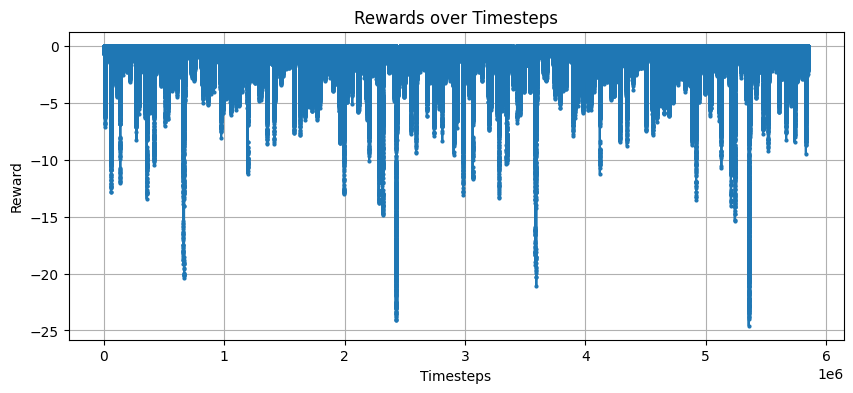

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(rewards.flatten(), marker='o', markersize=2, linestyle='-')
plt.title("Rewards over Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.grid(True)
plt.show()